<a href="https://colab.research.google.com/github/grewe/StrokeChangeMLTraining/blob/main/LabeledData-Eye-Classifier/Eye_Image_Classifier_with_Standard_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

#**ImageClassifier from Standard Tensorflow hub model -retrain, eval and test**


### In this colab notebook, you'll learn how to
 

*  train a custom image classifer from a pre-existing model 
*  tune parameters
*  evaluate it
*  run test cases and plot results
*  run tensorboard
*  save it to Saved_Model
*  export as TFLite


This colab is expecting the data to be already split into separate train, test and valid folders each containing subfolders - one per class. For example, in the classification of eyes for stroke patients we have the classes of normalEye, strokeEyeWeak, strokeEyeMid, strokeEyeSevere.  Hence the train and test and valid folders will contain the following sub-folders

*  test/normalEye
*  test/strokeEyeWeak
*  test/strokeEyeMid
*  test/strokeEyeSevere




#### **IMPORTANT:  TWO OPTIONS for training 1= from scratch and 2=from a checkpoint (i.e. if colab stopped and you had to restart training).    This will effect the following cells of evaluation and exporting.  NOTE: this is a work around because the Model Maker API does not yet support loading from checkpoints to train.   UNFORTUANTELY, this means that what happens is the underlying Object Detection API is used which requires a slightly different data input and all of this is prepared for you.**  

*   #### **BOTH options export and work in the default Model Maker Android app as shown in below in a screenshot (I tested it)**


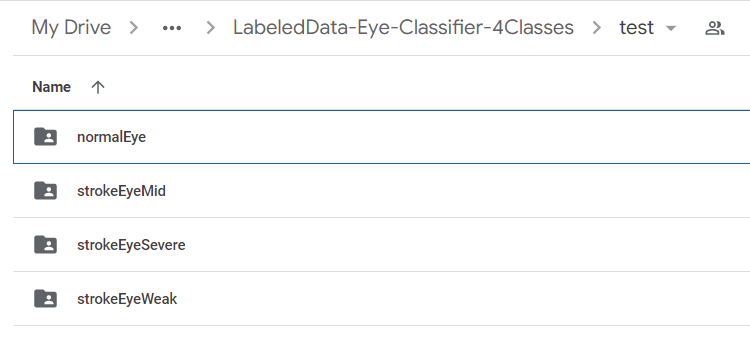

In [ ]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# STEP 0: mount Drive and install libraries and import packages

### assumes data in drive/Mask/MaskDetect/data


Here you'll use the dataset given in the zip file (http://borg.csueastbay.edu/~grewe/CS663/Mat/TensorFlow/TensorFlowLiteModelMaker/data.zip).

*  grab the zip and unzip and upload the content to your drive in the path YOUDRIVE/Mask/MaskDetect

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## STEP 1:  SETUP

In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

## Select the TF2 SavedModel module to use & specify BATCH_SIZE, determine IMAGE_SIZE to allign with model input size

For starters, use [https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4). The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that models in TF1 Hub format won't work here.)

You can find more TF2 models that generate image feature vectors [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2).

There are multiple possible models to try. All you need to do is select a different one on the cell below and follow up with the notebook.

In [ ]:
#@title

model_name = "efficientnetv2-b0" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16 #@param {type:"integer"}
print(f"Batch size {BATCH_SIZE}")

# STEP 2:  Set up the  dataset

Again assumes that the data is already augmented as desired and stored in google drive under train, test, valid  with sub-directories of class names.

In [ ]:
# setup the directory names

image_dir="drive/MyDrive/LabeledData-Eye-Classifier-4Classes"
print("image_dir\n")
print(image_dir)

test_dir="drive/MyDrive/LabeledData-Eye-Classifier-4Classes/test"
train_dir="drive/MyDrive/LabeledData-Eye-Classifier-4Classes/train"
valid_dir="drive/MyDrive/LabeledData-Eye-Classifier-4Classes/valid"


print(train_dir)
print(valid_dir)
print(test_dir)

%ls -1 {train_dir} | wc -l
%ls -1 {valid_dir} | wc -l
%ls -1 {test_dir} | wc -l

## PROBLEM --what is repeat in the next code block?

Repeat is specified for infinite datasets. In such case steps per epoch needs to be defined in model.fit()

In [ ]:
# see for documentaton on dataset creation https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
# will resize the images as appropriate to IMAGE_SIZExIMAGE_SIZE as defined above by model selection


#SETUP TRAINING DATA  tf.data.Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      train_dir,
      label_mode="categorical",
      image_size=IMAGE_SIZE,
      batch_size=BATCH_SIZE)


#determine classnames
class_names = tuple(train_ds.class_names)

#batch the training data by BATCH_SIZE specified above
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)

# setup images so will be rescaled as input from 0to255 to 0.0 to 1.0
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

#SETUP TEST Dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      test_dir,
      label_mode="categorical",
      image_size=IMAGE_SIZE,
      batch_size=BATCH_SIZE)
#batch the training data by BATCH_SIZE specified above
test_size = test_ds.cardinality().numpy()
test_ds = test_ds.unbatch().batch(BATCH_SIZE)
test_ds = test_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))


#SETUP VALIDATION Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      test_dir,
      label_mode="categorical",
      image_size=IMAGE_SIZE,
      batch_size=BATCH_SIZE)
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))



# **STEP 3: Defining the model**

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [ ]:
do_fine_tuning = True #@param {type:"boolean"}

In [ ]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

#  **STEP 4: Training the model**

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.000001, momentum=0.9), # try one parameter tuning each training momentum=0.9, weight_decay=0.001
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

# see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint 
checkpoints_dir = "drive/MyDrive/LabeledData-Eye-Classifier-4Classes/checkpoints-learningrate-000001/checkpoint-{epoch:02d}.hdf5"

mc = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoints_dir, save_best_only=True, verbose=1, save_freq='epoch')   # save_weights_only=True

In [ ]:
import datetime

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
epochs = 2500

# hist = model.fit(
#     train_ds,
#     epochs=epochs, steps_per_epoch=steps_per_epoch,
#     validation_data=val_ds,
#     validation_steps=validation_steps,
#     callbacks=[mc]).history

log_dir = "Logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, update_freq='epoch')

model.fit(
    train_ds,
    epochs=epochs, 
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[tensorboard_callback,mc])



In [ ]:
# find the pid of the process using port 6006
!lsof -i:6006


In [ ]:
!kill 3060

In [ ]:
#load tensorboard
%load_ext tensorboard

%tensorboard --logdir drive/MyDrive/Logs/

In [ ]:
#@title
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"], color='orange')
plt.plot(hist["val_loss"], color='blue') 
plt.legend(["train", "val"], loc ="lower right")

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"], color='orange')
plt.plot(hist["val_accuracy"], color='blue')

plt.legend(["blue", "green"], loc ="lower right")
plt.legend(["train", "val"], loc ="lower right")

### **Load from saved weights**

In [ ]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.000001), # try one parameter tuning each training momentum=0.9, weight_decay=0.001
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [ ]:
#set number of epoch and batch_size to train and then train
epochs = 1000
batch_size = BATCH_SIZE

In [ ]:
# Evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
#path of model checkpoint
checkpoint_path = "drive/MyDrive/LabeledData-Eye-Classifier-4Classes/checkpoints-learningrate-000001/run2/checkpoint-971.hdf5"

# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
import datetime

epochs = 1000

log_dir = "Logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, update_freq='epoch')

model.fit(
    train_ds,
    epochs=epochs, 
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[tensorboard_callback,mc])

# **STEP 5:  test** -Try out the model on an image from the **test** data:

In [ ]:
x, y = next(iter(test_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0]) #this seems wrong
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])


# **QUESTION --did I fix the iterator to only get unique samples from test_ds**

In [ ]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot  100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.

plt.figure(figsize=(30, 30))
pred=[]
truth=[]
predicts = model.predict(test_ds)
#predicts = model.predict_top_k(test_ds)
# takes 100 images at a time
for i, (image, label) in enumerate(test_ds.unbatch().take(64)):
  ax = plt.subplot(8, 8, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  predicted_index = np.argmax(predicts[i])
  predict_label = class_names[predicted_index]
  
  true_index = np.argmax(label)
  truth_label = class_names[true_index]

  color = get_label_color(predict_label, truth_label)
  ax.xaxis.label.set_color(color)
  #plt.xlabel('Predicted: %s \n Truth %s',  predict_label, test_data.index_to_label[label.numpy()])
  plt.xlabel('Pred: %s \n Truth %s' % (predict_label, truth_label))
  truth.append(truth_label)
  pred.append(predict_label)
plt.show()


In [ ]:
# Implement confusion matrix

import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


print(truth)
print(pred)


confusion_matrix = metrics.confusion_matrix(truth, pred, normalize=None)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["normalEye","strokeEyeMid","strokeEyeSevere","strokeEyeWeak"])


cm_display.plot()
plt.xticks(rotation=90)
plt.figure(figsize=(100, 100))
plt.show()

# **STEP 6: Save model as TFlite**

Finally, the trained model can be saved for deployment to TF Serving or TFLite (on mobile) as follows.

In [ ]:
saved_model_path = f"drive/MyDrive/LabeledData-Eye-Classifier-4Classes/checkpoints-learningrate-000001/models-new/{model_name}"
tf.saved_model.save(model, saved_model_path)

In [ ]:
# convert saved model to tflite

import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('drive/MyDrive/LabeledData-Eye-Classifier-4Classes/checkpoints-learningrate-000001/models/model-3500.tflite', 'wb') as f:
  f.write(tflite_model)

## NOT TESTED YET: Deployment to TensorFlow Lite

[TensorFlow Lite](https://www.tensorflow.org/lite) lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TFLite and apply post-training tools from the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization). Finally, it runs it in the TFLite Interpreter to examine the resulting quality

  * Converting without optimization provides the same results as before (up to roundoff error).
  * Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
  * On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like Edge TPU.

In [ ]:
#@title Optimization settings
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/tmp/lite_flowers_model_{model_name}.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

In [ ]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TFLite Interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [ ]:
#@markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TFLite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TFLite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))